# **SIS: Data Collection & Preparation**

Тема: Касса vs. рейтинги фильмов

H0: Кассовые сборы и рейтинг фильма не связаны.

H1: С ростом кассовых сборов рейтинг фильма увеличивается.

Выборка: Топ 1000 фильмов по кассовым сборам.

In [5]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data gathering: Webscraping

In [6]:
BASE_URL = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWW"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def fetch(offset):
    """
    Функция получает данные о фильмах с одной страницы сайта Box Office Mojo.
    На сайте 5 страниц, каждая содержит по 200 фильмов, всего 1000 фильмов.
    """
    if offset == 0:
        URL = BASE_URL
    else:
        URL = f"{BASE_URL}&offset={offset}"

    response = requests.get(URL, headers=HEADERS)
    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table")
    header_tags = table.select("th")
    headers = []

    for i in header_tags:
        headers.append(i.text.strip())

    title_index = headers.index("Title")
    gross_index = headers.index("Lifetime Gross")
    year_index = headers.index("Year")

    movie_rows = table.select("tr")
    movies = []

    for i in movie_rows:
        cells = i.select("td")
        if len(cells) < 4:
            continue

        title = cells[title_index].text.strip()
        gross = cells[gross_index].text.strip()
        year = cells[year_index].text.strip()

        movies.append({
            "Title": title,
            "Lifetime Gross": gross,
            "Year": year
        })

    return movies

all_movies, offset = [], 0

while len(all_movies) < 1000:
    page_movies = fetch(offset)
    all_movies.extend(page_movies)
    offset += 200
    time.sleep(0.2)

df_webscrap = pd.DataFrame(all_movies)

In [2]:
# print(df_webscrap.head(20).to_string())

Data gathering: API

In [ ]:
# несколько апи ключей, на случай если истощатся (OMBDapi позволяет только 1000 зарпосов каждые 24 часа)
# можно попробовать имплементировать подмену ключей или error-handler: если ключ умирает, заканчивать скрипт (done)

# 1a251b79 истощён
# 6b8a4ffa истощён
# 2f7722e0 тестировалось малое количествл запросов
# Неюзанный новый ключ: 9a39e74d
# f52f2990 истощён

In [ ]:
OMDB_API_KEY = "f52f2990"
OMDB_URL = "http://www.omdbapi.com/"

rows = []
consecutive_none = 0

for i in range(len(df_webscrap)):
    title = df_webscrap.loc[i, "Title"]
    year  = df_webscrap.loc[i, "Year"]
    params = {"t": title, "y": year, "type": "movie", "apikey": OMDB_API_KEY}
    data = requests.get(OMDB_URL, params=params, timeout=15).json()

    # error handler
    if data.get("Title") is None:
        consecutive_none += 1
        if consecutive_none >= 30:
            print("Key exhausted")
            break
        continue
    else:
        consecutive_none = 0

    rows.append({
        "Title": data.get("Title"),
        "Year": data.get("Year"),
        "imdbRating": data.get("imdbRating"),
        "Runtime": data.get("Runtime"),
        "Genre": data.get("Genre")
    })
    time.sleep(0.1)

df_api = pd.DataFrame(rows, columns=["Title","Year","imdbRating","Runtime","Genre"])

In [7]:
# Нужно будет сохранить 993 результата выданных апишкой в csv,
# чтобы каждый раз не истощать апи-ключи. И сохранить этот файл на комп
# df_api.to_csv("api_results.csv", index=False)

# Прировнять апи датафрейм к значениям сохранённой ранее csv-шке если сбросилось:
# df_api = pd.read_csv("api_results.csv")

len(df_api) # 993
# print(df_api.to_string())

993

Data Normalization & Merging

In [42]:
def norm_title(s):
    return s.replace("–", "-").strip()

# ВАЖНО! Создаём копию объединённого датафрейма, чтобы не изменять исходный df_merged.
# Если написать просто "left = df_webscrap" то все изменения, сделанные в left, отобразятся на df_webscrap !!!
left = df_webscrap.copy()
left["Title"] = left["Title"].apply(norm_title)
left["Year"] = left["Year"].astype("Int64")

right = df_api.copy()
right["Title"] = right["Title"].apply(norm_title)
right["Year"] = right["Year"].astype("Int64")

"""
Примечание: Можно было бы использовать how="inner" - тогда в итоговую таблицу попали бы только
фильмы, которые есть и в webscrap данных, и в api данных. Но тут специально выбран left join,
чтобы позже показать, как потом можно обрабатывать и очищать пропуски (NaN) в данных.
"""
df_merged = pd.merge(left, right, on=["Title","Year"], how="left")

In [43]:
# print(df_merged.head(20).to_string())
print(len(df_merged)) # 1000

1000


In [44]:
df_cleaned = df_merged.copy()

df_cleaned["LifetimeGross"] = df_cleaned["Lifetime Gross"].replace(r"[\$,]", "", regex=True).astype("Int64")
df_cleaned["imdbRating"] = df_cleaned["imdbRating"].astype("Float64")
df_cleaned["Duration"] = df_cleaned["Runtime"].str.extract(r"(\d+)").astype("Int64")
df_cleaned["MainGenre"] = df_cleaned["Genre"].str.split(",").str[0].str.strip()

df_cleaned = (df_cleaned.dropna(how="any")
              .drop_duplicates(subset=["Title","Year"]) # в целом дубликатов и так нет, но это так.
              .reset_index(drop=True)
)[["Title","Year","LifetimeGross","imdbRating","Duration","MainGenre"]]

In [31]:
# print(df_cleaned.head(20).to_string())
print(len(df_cleaned)) # 983

983


Data Analysis

In [32]:
rating = df_cleaned["imdbRating"]
print("IMDb min raiting:", rating.min())
print("IMDb max raiting:", rating.max())
print("IMDb mean value:", round(rating.mean(), 2))
print("IMDb standard deviation:", round(rating.std(), 2))

IMDb min raiting: 2.1
IMDb max raiting: 9.2
IMDb mean value: 6.83
IMDb standard deviation: 0.88


In [33]:
durations = df_cleaned["Duration"]
print("Mean duration:", round(durations.mean()), "min")

imin = durations.idxmin()
imax = durations.idxmax()
print("Shortest:", df_cleaned.loc[imin, "Title"], "-", df_cleaned.loc[imin, "Duration"], "min")
print("Longest:", df_cleaned.loc[imax, "Title"], "-", df_cleaned.loc[imax, "Duration"], "min")

Mean duration: 119 min
Shortest: Bambi - 69 min
Longest: Gone with the Wind - 238 min


In [34]:
genre_counts = df_cleaned["MainGenre"].value_counts()
print("Most common genre:", genre_counts.index[0], genre_counts.iloc[0])
print(genre_counts.to_string())

mean_rating_by_genre = df_cleaned.groupby("MainGenre")["imdbRating"].mean().sort_values(ascending=False)
print("\nMean IMDb by genre top:")
print(mean_rating_by_genre.round(1).to_string())

mean_gross_by_genre = df_cleaned.groupby("MainGenre")["LifetimeGross"].mean().sort_values(ascending=False)
print("\nMean gross by genre top:")
print(mean_gross_by_genre.astype(int).to_string())

Most common genre: Action 440
MainGenre
Action         440
Animation      174
Comedy         120
Adventure       90
Drama           75
Biography       30
Crime           22
Horror          22
Fantasy          4
Mystery          3
Documentary      3

Mean IMDb by genre top:
MainGenre
Biography      7.7
Crime          7.6
Documentary    7.6
Fantasy        7.2
Drama          7.2
Animation      7.0
Adventure      6.8
Mystery        6.7
Action         6.7
Comedy         6.6
Horror         6.6

Mean gross by genre top:
MainGenre
Mystery        502861287
Animation      499168417
Adventure      499008308
Action         494722473
Drama          350171433
Fantasy        345441489
Crime          323107096
Biography      316318606
Comedy         309498449
Horror         306921513
Documentary    250695579


In [35]:
# Без "as_index=False" Year становится индексом, а не колонкой, поэтому sort_values("Year") не находит такую колонку.
gross_by_year = df_cleaned.groupby("Year", as_index=False)["LifetimeGross"].sum().sort_values("Year")
print("Top-15 years by total gross:")
# Без "index=False" показываются индексы
print(gross_by_year.sort_values("LifetimeGross", ascending=False).head(15).to_string(index=False))

Top-15 years by total gross:
 Year  LifetimeGross
 2019    26064074460
 2017    24557900685
 2018    24441970658
 2016    22246438191
 2015    20503361830
 2014    19535016723
 2012    19269497862
 2013    18732442866
 2023    17921187779
 2011    15832687417
 2010    15743699331
 2009    15529530134
 2024    15243632528
 2022    14828890484
 2008    13782691946


In [36]:
"""
Коэффициент корреляции Пирсона — это статистический показатель, который измеряет силу и направление
линейной связи между двумя количественными переменными, принимая значения от -1 до +1. Значение
+1 означает полную положительную связь, -1 полную отрицательную связь, а 0 отсутствие линейной связи.
"""
d = df_cleaned.copy()
d["log_gross"] = np.log10(d["LifetimeGross"])
d["Gross group"] = pd.qcut(d["LifetimeGross"], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
# Считаем коэффициент корреляции Пирсона
r = np.corrcoef(d["log_gross"], d["imdbRating"])[0,1]

print("Pearson:", round(r, 2))
print("\nMean IMDb by gross quantile:")
print(d.groupby("Gross group", observed=True)["imdbRating"].mean().round(2).to_string())

Pearson: 0.25

Mean IMDb by gross quantile:
Gross group
Q1    6.63
Q2    6.65
Q3    6.75
Q4    6.93
Q5     7.2


Data Visualization

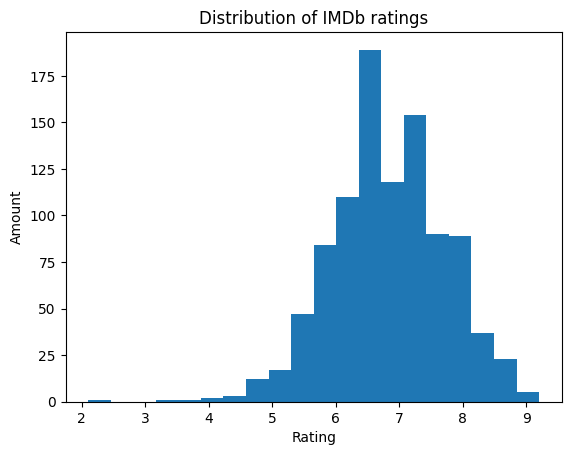

In [37]:
v = pd.to_numeric(df_cleaned["imdbRating"])
plt.hist(v, bins=20)
plt.title("Distribution of IMDb ratings"); plt.xlabel("Rating"); plt.ylabel("Amount")
plt.show()

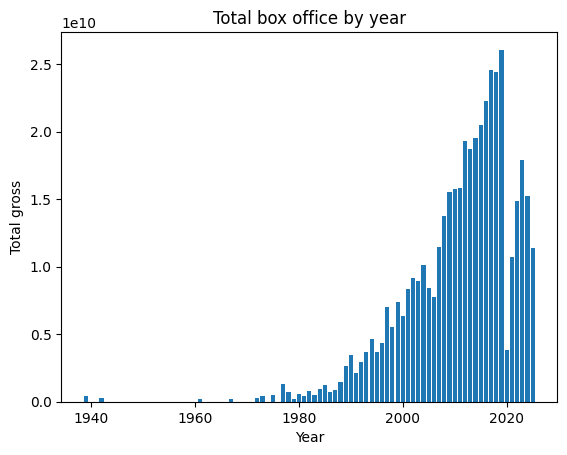

In [38]:
v2 = df_cleaned.groupby("Year", as_index=False)["LifetimeGross"].sum()
plt.bar(v2["Year"], v2["LifetimeGross"])
plt.title("Total box office by year"); plt.xlabel("Year"); plt.ylabel("Total gross")
plt.show()

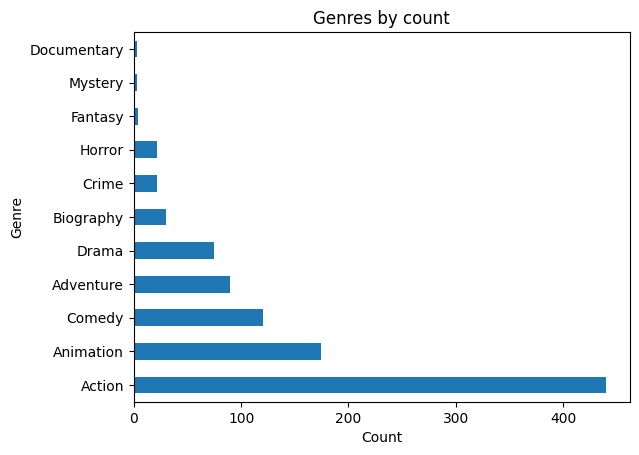

In [39]:
v3 = df_cleaned["MainGenre"].value_counts()
v3.plot(kind="barh")
plt.title("Genres by count"); plt.xlabel("Count"); plt.ylabel("Genre")
plt.show()

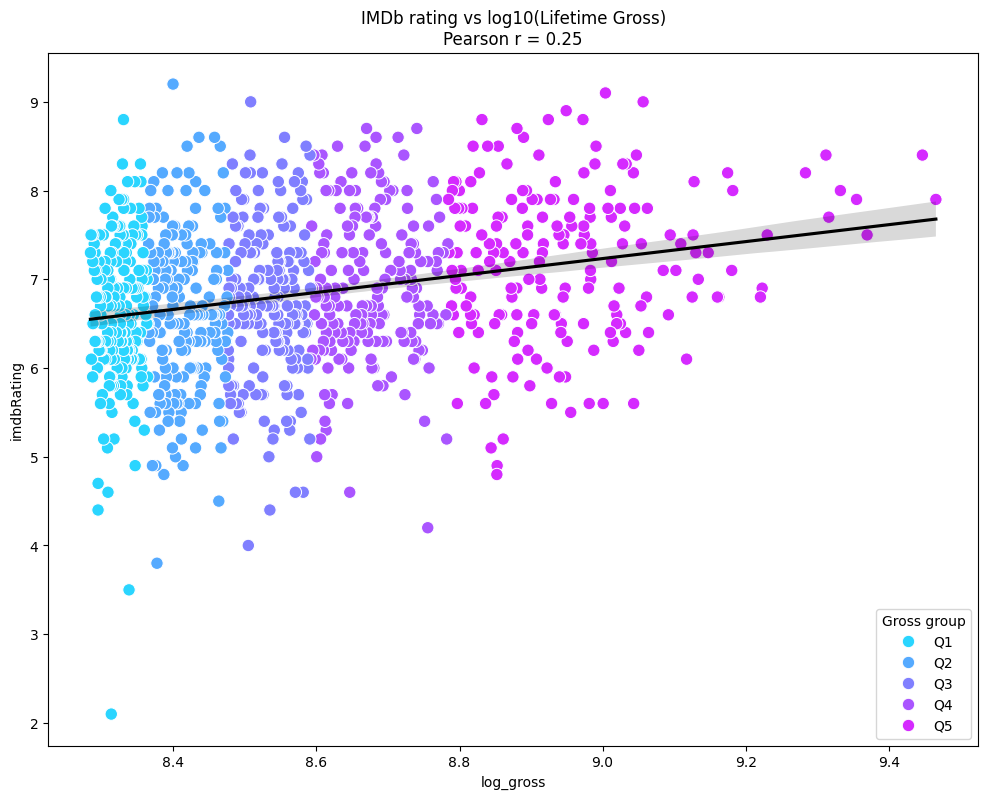

In [40]:
plt.figure(figsize=(12,9))
sns.scatterplot(data=d, x="log_gross", y="imdbRating", hue="Gross group", palette="cool", s=80)
sns.regplot(data=d, x="log_gross", y="imdbRating", scatter=False, color="black")
plt.title(f"IMDb rating vs log10(Lifetime Gross)\nPearson r = 0.25")
plt.show()

**Thank you for the attention.**